In [1]:
# ===============================================================
# CMSE 492 – Project: Predicting Exfoliation Energy of 2D Materials
# Author: Artemiy Filippov
# ===============================================================

# ===============================================================
# PART A: Setup and Imports
# ===============================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matminer.datasets import load_dataset
from matminer.featurizers.structure import DensityFeatures
from matminer.featurizers.composition import ElementProperty

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap

# Directory setup
FIG_DIR = Path("../../figures")
DATA_DIR = Path("../../data")
PROC_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

for d in [FIG_DIR, PROC_DIR, RAW_DIR]:
    d.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid", context="talk")

In [2]:
# ===============================================================
# PART B1: Load Dataset
# ===============================================================

df = load_dataset("matbench_jdft2d")
print(f"✅ Dataset loaded successfully: {df.shape[0]} samples, {df.shape[1]} columns")
display(df.head())

print("""
Dataset: MatBench JDFT-2D (Ward et al., 2020)
Source: Materials Project via Matminer
Target property: Exfoliation energy (eV/atom)
""")

# Save small raw sample
df.sample(50, random_state=42).to_csv(PROC_DIR / "sample_raw.csv", index=False)


# ===============================================================
# PART B2: Feature Generation
# ===============================================================

# Add composition column
df["composition"] = df["structure"].apply(lambda s: s.composition)

# Featurizers
density_feat = DensityFeatures()
magpie_feat = ElementProperty.from_preset("magpie")

# Apply featurization
df_feat = density_feat.featurize_dataframe(df.copy(), col_id="structure", ignore_errors=True)
df_feat = magpie_feat.featurize_dataframe(df_feat, col_id="composition", ignore_errors=True)

# Add target and clean
df_feat["exfoliation_en"] = df["exfoliation_en"].values
df_feat = df_feat.select_dtypes("number").dropna()

print("✅ Numeric features ready:", df_feat.shape)
display(df_feat.head())

# Save processed sample
df_feat.sample(50, random_state=0).to_csv(PROC_DIR / "sample_processed.csv", index=False)

✅ Dataset loaded successfully: 636 samples, 2 columns


,structure,exfoliation_en
0,"[[1.49323139 3.32688406 7.26257785] Hf, [3.326...",63.593833
1,"[[1.85068084 4.37698238 6.9301577 ] As, [0. ...",134.863750
2,"[[ 0. 2.0213325 11.97279555] Ti, [ 1...",43.114667
3,"[[2.39882726 2.39882726 2.53701553] In, [0.054...",240.715488
4,[[-1.83484554e-06 1.73300105e+00 2.61675943e...,67.442833



Dataset: MatBench JDFT-2D (Ward et al., 2020)
Source: Materials Project via Matminer
Target property: Exfoliation energy (eV/atom)



/opt/anaconda3/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


DensityFeatures:   0%|          | 0/636 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/636 [00:00<?, ?it/s]

✅ Numeric features ready: (635, 136)


,exfoliation_en,density,vpa,packing fraction,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,63.593833,3.021472,61.218660,0.177875,14.0,72.0,58.0,46.000000,21.333333,14.0,...,0.000000,0.000000,0.00000,0.0,152.0,227.0,75.0,191.000000,26.000000,152.0
1,134.863750,1.124487,110.637295,0.057581,33.0,33.0,0.0,33.000000,0.000000,33.0,...,0.000000,0.000000,0.00000,0.0,166.0,166.0,0.0,166.000000,0.000000,166.0
2,43.114667,1.385515,57.436271,0.108929,8.0,35.0,27.0,21.666667,9.111111,8.0,...,0.000023,0.000008,0.00001,0.0,12.0,194.0,182.0,90.000000,69.333333,12.0
3,240.715488,1.950268,137.847700,0.118812,49.0,83.0,34.0,66.000000,17.000000,49.0,...,0.000000,0.000000,0.00000,0.0,12.0,139.0,127.0,75.500000,63.500000,12.0
4,67.442833,1.183135,58.435112,0.083167,8.0,41.0,33.0,19.000000,14.666667,8.0,...,0.000000,0.000000,0.00000,0.0,12.0,229.0,217.0,84.333333,96.444444,12.0


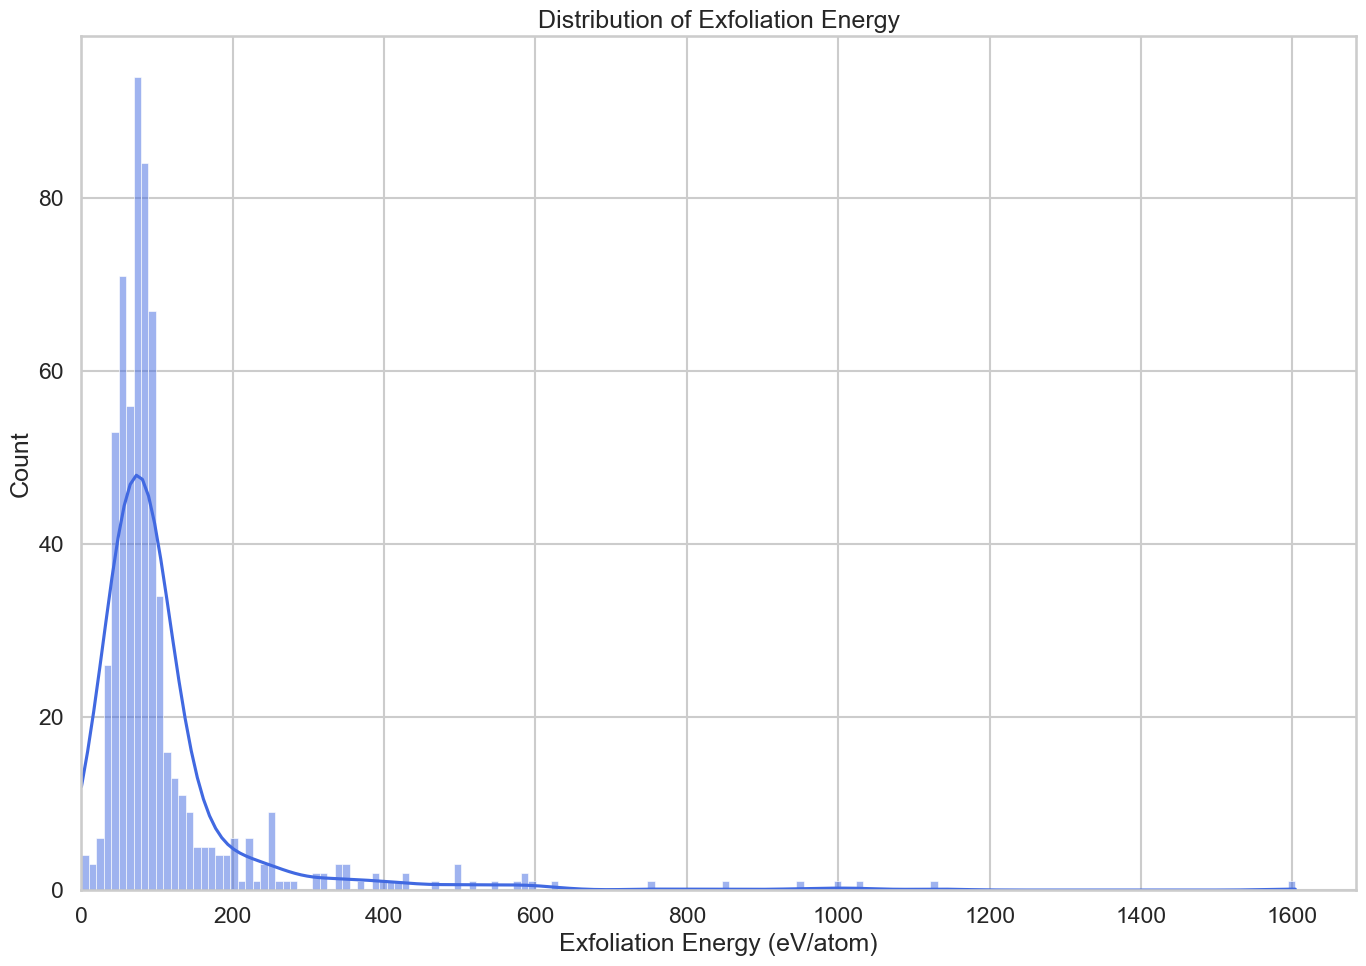

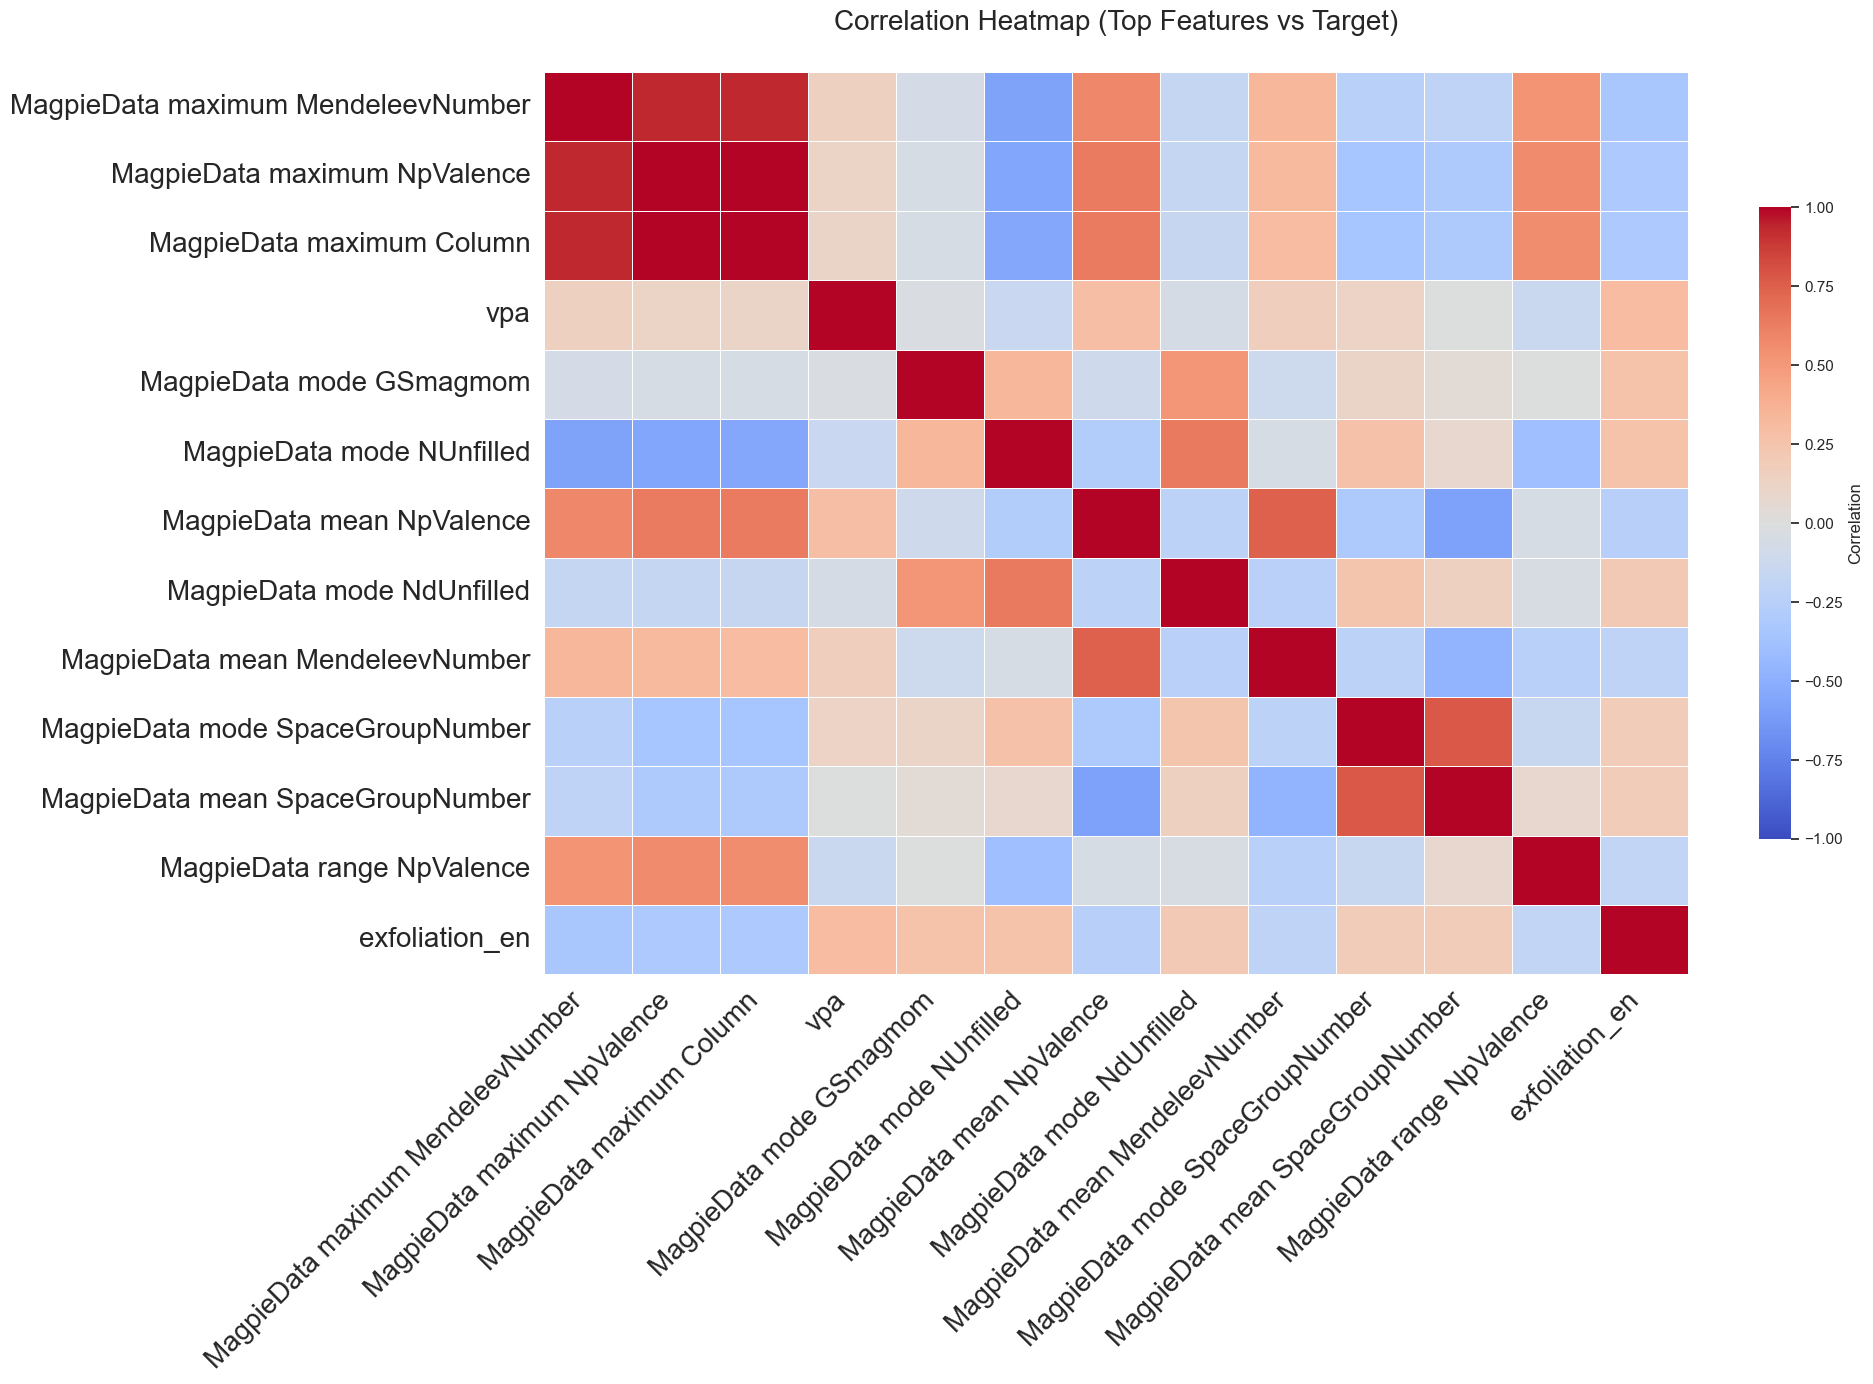

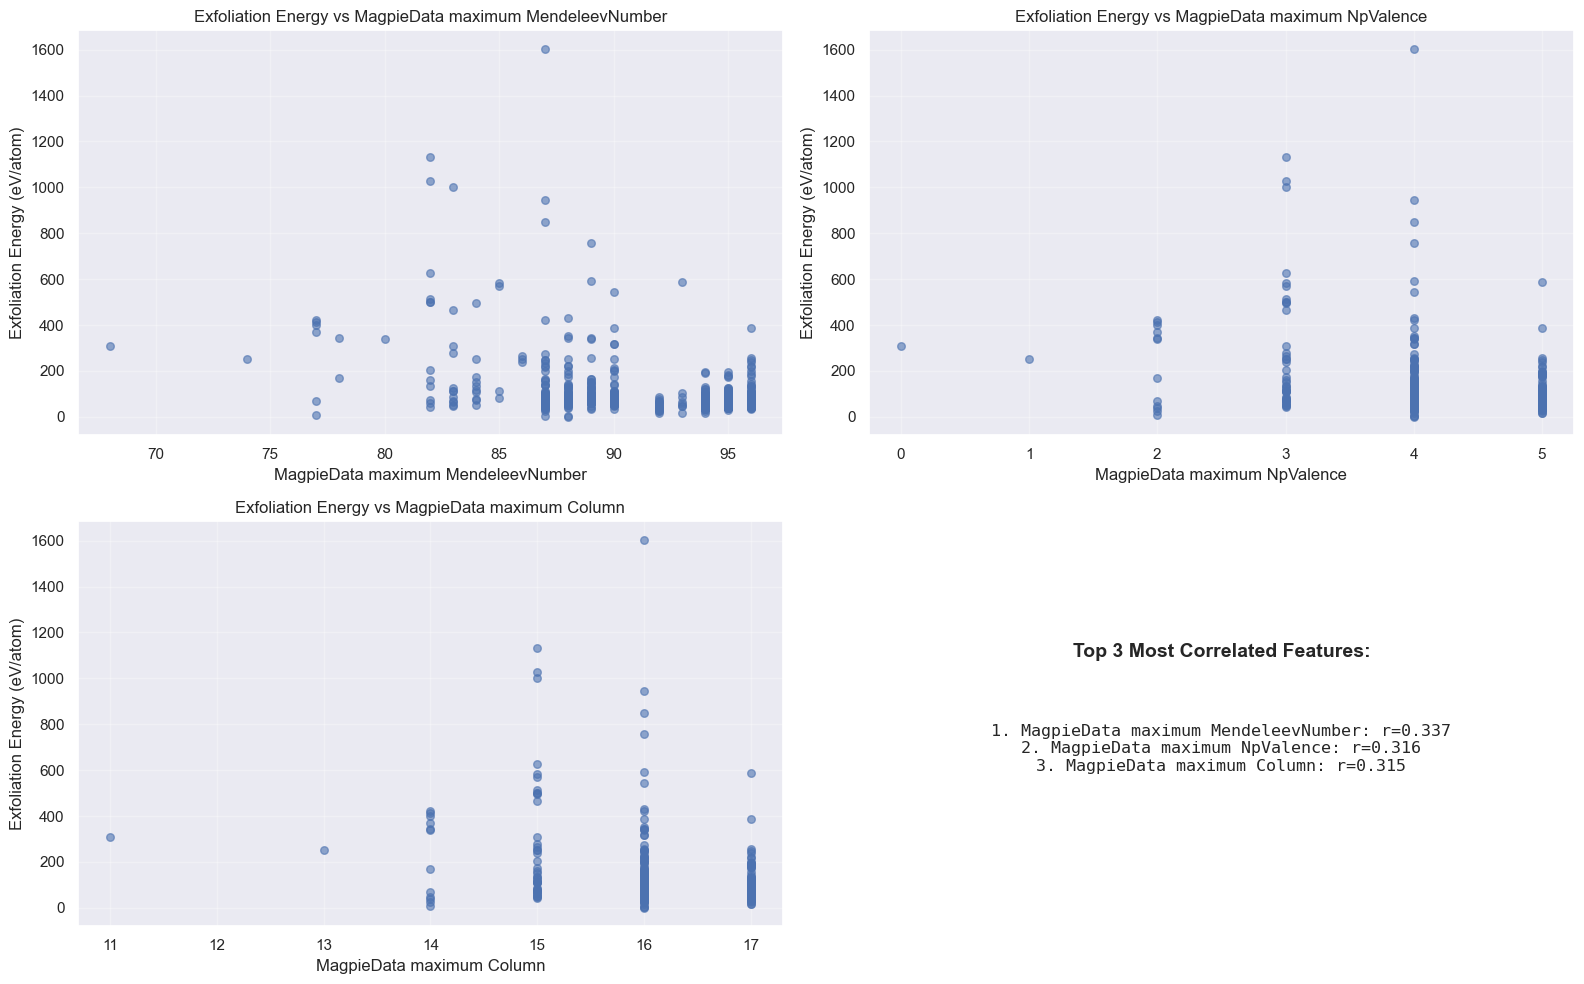


Top 10 Features Correlated with Exfoliation Energy:
 1. MagpieData maximum MendeleevNumber       |r| = 0.3367
 2. MagpieData maximum NpValence             |r| = 0.3161
 3. MagpieData maximum Column                |r| = 0.3147
 4. vpa                                      |r| = 0.3124
 5. MagpieData mode GSmagmom                 |r| = 0.2626
 6. MagpieData mode NUnfilled                |r| = 0.2613
 7. MagpieData mean NpValence                |r| = 0.2519
 8. MagpieData mode NdUnfilled               |r| = 0.2138
 9. MagpieData mean MendeleevNumber          |r| = 0.2105
10. MagpieData mode SpaceGroupNumber         |r| = 0.1901


In [3]:
# ===============================================================
# PART C1: Exploratory Data Analysis - Target Distribution
# ===============================================================

plt.figure(figsize=(14,10))
sns.histplot(df_feat["exfoliation_en"], kde=True, color="royalblue")
plt.xlabel("Exfoliation Energy (eV/atom)")
plt.ylabel("Count")
plt.title("Distribution of Exfoliation Energy")
plt.xlim(0)
plt.tight_layout()
plt.savefig(FIG_DIR / "exfoliation_distribution.png", dpi=300)
plt.show()

# ===============================================================
# PART C2 (Improved): Exploratory Data Analysis - Correlation Heatmap
# ===============================================================

# Compute correlations
corr = df_feat.corr(numeric_only=True)
target_corr = corr["exfoliation_en"].drop("exfoliation_en").abs().sort_values(ascending=False)

# Select top features + target
top_feats = list(target_corr.head(12).index) + ["exfoliation_en"]
corr_matrix = df_feat[top_feats].corr()

# Plot
plt.figure(figsize=(20, 14))
sns.set(font_scale=1.0)

ax = sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    annot=False,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7, "label": "Correlation"},
)

plt.title("Correlation Heatmap (Top Features vs Target)", fontsize=20, pad=30)

# Rotate labels for readability
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(rotation=0, fontsize=20)

plt.tight_layout()
plt.savefig(FIG_DIR / "feature_correlation_heatmap.png", dpi=300)
plt.show()

# ===============================================================
# PART C3: Exploratory Data Analysis - Key Feature Relationships
# ===============================================================

# Create a 2x2 grid showing relationships with top 3 features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top 3 correlated features
top_3_features = list(target_corr.head(3).index)

for idx, feature in enumerate(top_3_features):
    row = idx // 2
    col = idx % 2
    axes[row, col].scatter(df_feat[feature], df_feat["exfoliation_en"], alpha=0.6, s=30)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("Exfoliation Energy (eV/atom)")
    axes[row, col].set_title(f"Exfoliation Energy vs {feature}")
    axes[row, col].grid(True, alpha=0.3)

# Use the 4th subplot for a summary
axes[1, 1].axis('off')
axes[1, 1].text(0.5, 0.7, 'Top 3 Most Correlated Features:', 
                ha='center', va='top', fontsize=14, fontweight='bold')
summary_text = '\n'.join([f"{i+1}. {feat}: r={target_corr[feat]:.3f}" 
                          for i, feat in enumerate(top_3_features)])
axes[1, 1].text(0.5, 0.5, summary_text, ha='center', va='top', 
                fontsize=12, family='monospace')

plt.tight_layout()
plt.savefig(FIG_DIR / "top_features_vs_target.png", dpi=300)
plt.show()

# Print feature statistics
print("\nTop 10 Features Correlated with Exfoliation Energy:")
print("="*60)
for i, (feat, corr_val) in enumerate(target_corr.head(10).items(), 1):
    print(f"{i:2d}. {feat:40s} |r| = {corr_val:.4f}")



FEATURE SELECTION

1. Original features: 135
   After variance filter: 127 features
   Removed: 8 low-variance features

2. Removing highly correlated features (|r| > 0.95)...
   Found 33 highly correlated features to remove
   Final feature count: 94

✅ Reduced from 135 to 94 features (41 removed)

Top 10 features (by correlation with target) that were retained:
   1. MagpieData maximum MendeleevNumber       |r| = 0.3367
   2. MagpieData maximum Column                |r| = 0.3147
   3. vpa                                      |r| = 0.3124
   4. MagpieData mode NUnfilled                |r| = 0.2613
   5. MagpieData mean NpValence                |r| = 0.2519
   6. MagpieData mode NdUnfilled               |r| = 0.2138
   7. MagpieData mean MendeleevNumber          |r| = 0.2105
   8. MagpieData mode SpaceGroupNumber         |r| = 0.1901
   9. MagpieData mean SpaceGroupNumber         |r| = 0.1901
  10. MagpieData range NpValence               |r| = 0.1875


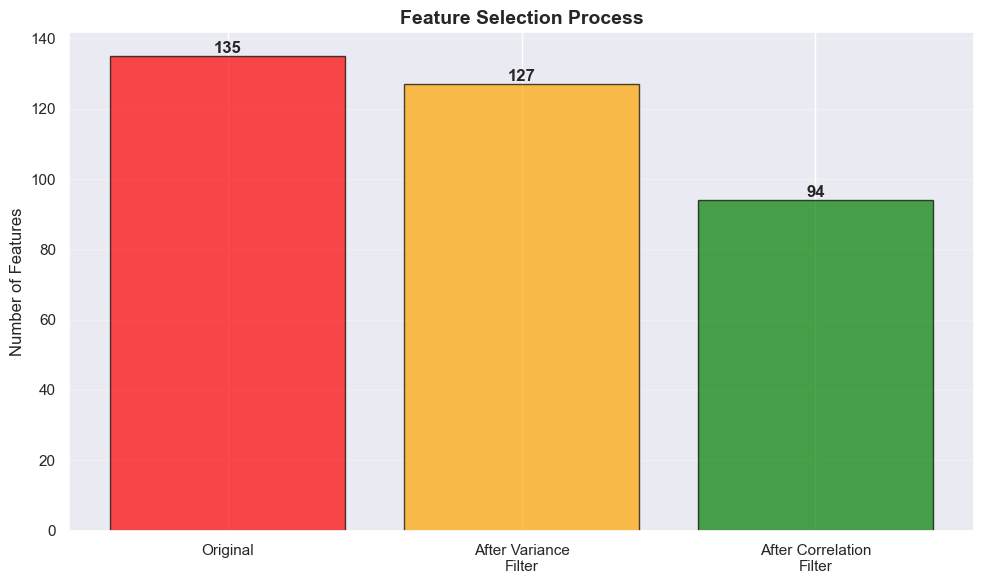

In [5]:
# ===============================================================
# PART C4: Feature Selection
# ===============================================================

print("\n" + "="*70)
print("FEATURE SELECTION")
print("="*70)

from sklearn.feature_selection import VarianceThreshold

# Create X from df_feat (this is what Part D does, but we need it earlier)
X_original = df_feat.drop(columns=["exfoliation_en"])

# Step 1: Remove low-variance features
print(f"\n1. Original features: {X_original.shape[1]}")

selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
X_var_filtered = pd.DataFrame(
    selector.fit_transform(X_original),
    columns=X_original.columns[selector.get_support()],
    index=X_original.index
)

print(f"   After variance filter: {X_var_filtered.shape[1]} features")
print(f"   Removed: {X_original.shape[1] - X_var_filtered.shape[1]} low-variance features")

# Step 2: Remove highly correlated features (correlation > 0.95)
print(f"\n2. Removing highly correlated features (|r| > 0.95)...")

corr_matrix = X_var_filtered.corr().abs()

# Upper triangle of correlation matrix
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > 0.95
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

print(f"   Found {len(to_drop)} highly correlated features to remove")

# Keep uncorrelated features
X_selected = X_var_filtered.drop(columns=to_drop)

print(f"   Final feature count: {X_selected.shape[1]}")
print(f"\n✅ Reduced from {X_original.shape[1]} to {X_selected.shape[1]} features ({X_original.shape[1] - X_selected.shape[1]} removed)")

# Optional: Show which features were kept
print(f"\nTop 10 features (by correlation with target) that were retained:")
retained_features = X_selected.columns.tolist()
top_retained = [feat for feat in target_corr.head(20).index if feat in retained_features][:10]
for i, feat in enumerate(top_retained, 1):
    print(f"  {i:2d}. {feat:40s} |r| = {target_corr[feat]:.4f}")

# Visualization: Compare feature counts
fig, ax = plt.subplots(figsize=(10, 6))
stages = ['Original', 'After Variance\nFilter', 'After Correlation\nFilter']
counts = [X_original.shape[1], X_var_filtered.shape[1], X_selected.shape[1]]
colors = ['red', 'orange', 'green']

bars = ax.bar(stages, counts, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature Selection Process', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(FIG_DIR / "feature_selection.png", dpi=300)
plt.show()


BASELINE MODEL: LINEAR REGRESSION
CV MAE:  71.788 ± 7.624 eV/atom
CV RMSE: 126.578 ± 26.460 eV/atom

Test MAE:  57.845 eV/atom
Test RMSE: 87.674 eV/atom
Test R²:   0.026

----------------------------------------------------------------------
OVERFITTING/UNDERFITTING ANALYSIS:
----------------------------------------------------------------------
Train MAE: 59.793 eV/atom
Test MAE:  57.845 eV/atom
Train R²:  0.515
Test R²:   0.026

Gap (Test - Train): -1.948 eV/atom
Test/Train Ratio:   0.967
⚠️  UNDERFITTING - Model is too simple, both errors are high


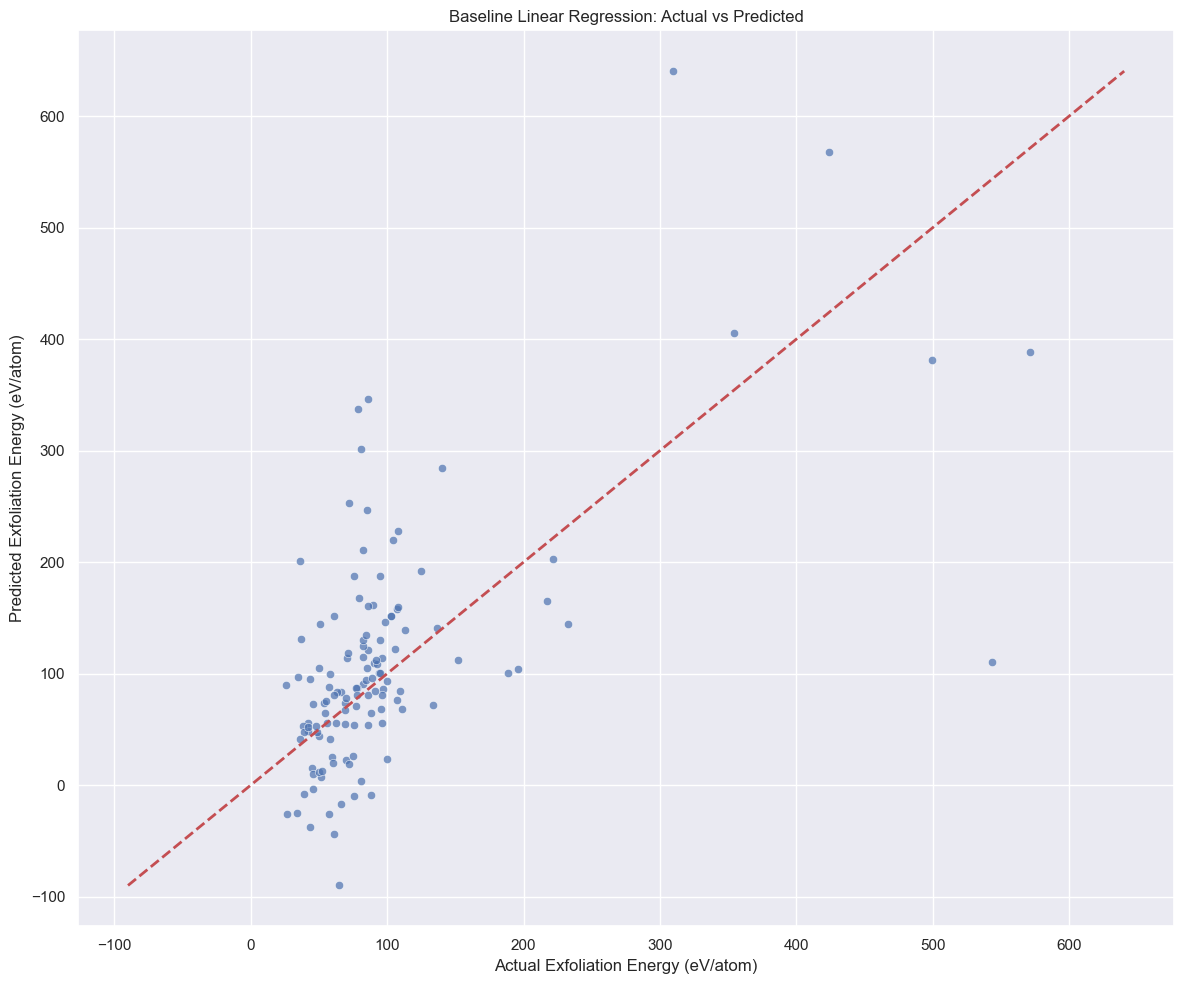

In [6]:
# ===============================================================
# PART D: Baseline Model - Linear Regression
# ===============================================================

print("\n" + "="*70)
print("BASELINE MODEL: LINEAR REGRESSION")
print("="*70)

# Use selected features
X = X_selected
y = df_feat["exfoliation_en"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaled pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = -cross_val_score(pipe, X, y, scoring="neg_mean_absolute_error", cv=cv)
cv_rmse = np.sqrt(-cross_val_score(pipe, X, y, scoring="neg_mean_squared_error", cv=cv))

print(f"CV MAE:  {cv_mae.mean():.3f} ± {cv_mae.std():.3f} eV/atom")
print(f"CV RMSE: {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f} eV/atom")

# Train/test metrics
pipe.fit(X_train, y_train)

# Test predictions
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

# Train predictions
y_train_pred = pipe.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"\nTest MAE:  {mae:.3f} eV/atom")
print(f"Test RMSE: {rmse:.3f} eV/atom")
print(f"Test R²:   {test_r2:.3f}")

# Overfitting/Underfitting Check
print("\n" + "-"*70)
print("OVERFITTING/UNDERFITTING ANALYSIS:")
print("-"*70)
print(f"Train MAE: {train_mae:.3f} eV/atom")
print(f"Test MAE:  {mae:.3f} eV/atom")
print(f"Train R²:  {train_r2:.3f}")
print(f"Test R²:   {test_r2:.3f}")

gap = mae - train_mae
ratio = mae / train_mae
print(f"\nGap (Test - Train): {gap:.3f} eV/atom")
print(f"Test/Train Ratio:   {ratio:.3f}")

if ratio < 1.05:
    print("⚠️  UNDERFITTING - Model is too simple, both errors are high")
elif 1.05 <= ratio <= 1.20:
    print("✅ GOOD FIT - Healthy generalization")
elif 1.20 < ratio <= 1.40:
    print("⚠️  SLIGHT OVERFITTING - Some memorization")
else:
    print("❌ SEVERE OVERFITTING - Memorizing training data")

# Actual vs Predicted
plt.figure(figsize=(12,10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.xlabel("Actual Exfoliation Energy (eV/atom)")
plt.ylabel("Predicted Exfoliation Energy (eV/atom)")
plt.title("Baseline Linear Regression: Actual vs Predicted")
plt.tight_layout()
plt.savefig(FIG_DIR / "baseline_actual_vs_predicted.png", dpi=300)
plt.show()


RANDOM FOREST REGRESSOR
CV MAE:  45.267 ± 8.229 eV/atom
CV RMSE: 108.107 ± 34.805 eV/atom

Test MAE:  31.844 eV/atom
Test RMSE: 62.577 eV/atom
Test R²:   0.504
Improvement vs baseline: 45.0%

----------------------------------------------------------------------
OVERFITTING/UNDERFITTING ANALYSIS:
----------------------------------------------------------------------
Train MAE: 29.394 eV/atom
Test MAE:  31.844 eV/atom
Train R²:  0.683
Test R²:   0.504

Gap (Test - Train): 2.449 eV/atom
Test/Train Ratio:   1.083
✅ GOOD FIT - Healthy generalization


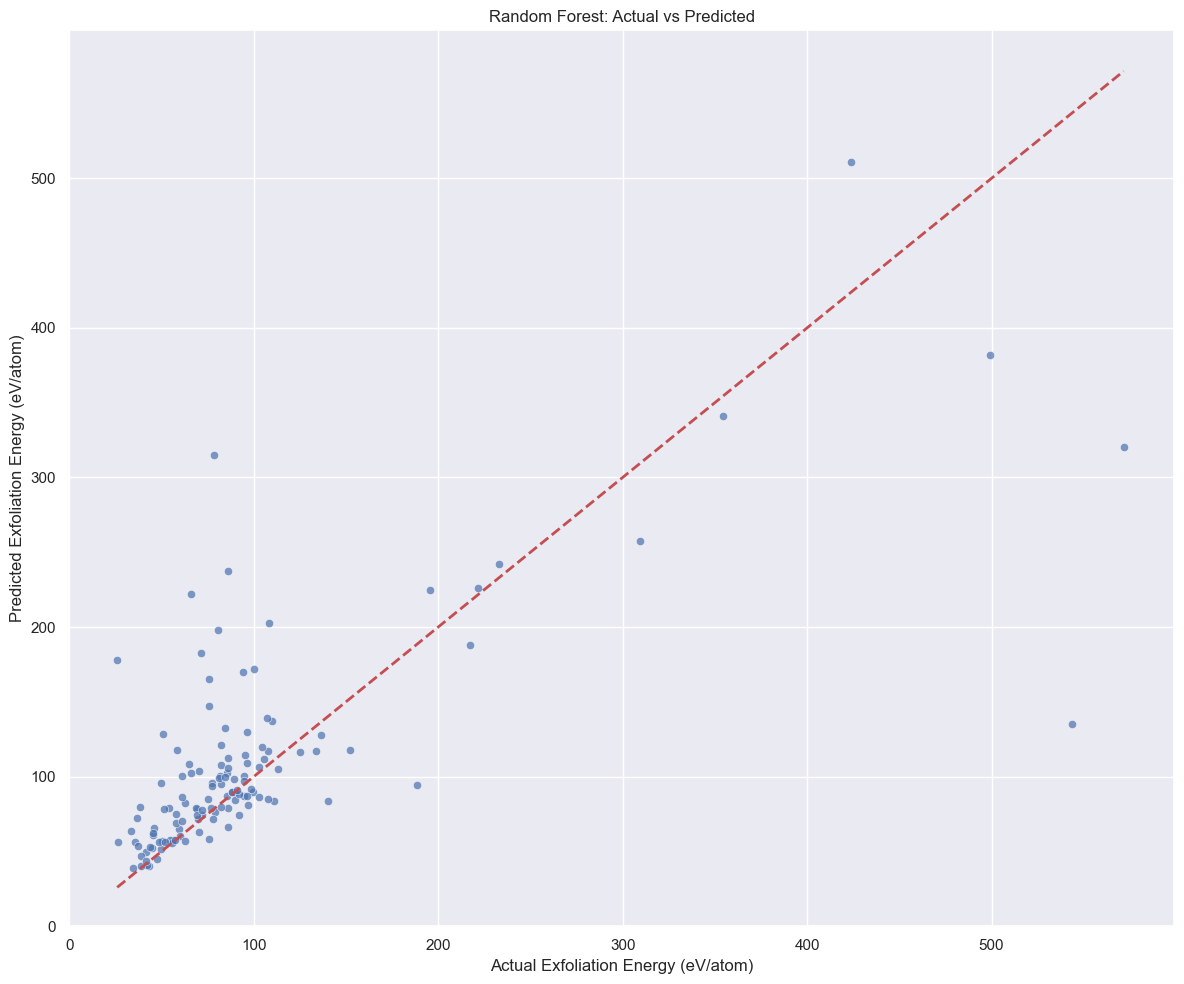

In [7]:
# ===============================================================
# PART E: Random Forest Model
# ===============================================================

print("\n" + "="*70)
print("RANDOM FOREST REGRESSOR")
print("="*70)

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", rf_model)
])

# Cross-validation
cv_mae_rf = -cross_val_score(rf_pipe, X, y, scoring="neg_mean_absolute_error", cv=cv)
cv_rmse_rf = np.sqrt(-cross_val_score(rf_pipe, X, y, scoring="neg_mean_squared_error", cv=cv))

print(f"CV MAE:  {cv_mae_rf.mean():.3f} ± {cv_mae_rf.std():.3f} eV/atom")
print(f"CV RMSE: {cv_rmse_rf.mean():.3f} ± {cv_rmse_rf.std():.3f} eV/atom")

# Train and test
rf_pipe.fit(X_train, y_train)

# Test predictions
y_pred_rf = rf_pipe.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_test_r2 = r2_score(y_test, y_pred_rf)

# Train predictions
y_train_pred_rf = rf_pipe.predict(X_train)
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_train_r2 = r2_score(y_train, y_train_pred_rf)

print(f"\nTest MAE:  {rf_mae:.3f} eV/atom")
print(f"Test RMSE: {rf_rmse:.3f} eV/atom")
print(f"Test R²:   {rf_test_r2:.3f}")
print(f"Improvement vs baseline: {((mae - rf_mae) / mae * 100):.1f}%")

# Overfitting/Underfitting Check
print("\n" + "-"*70)
print("OVERFITTING/UNDERFITTING ANALYSIS:")
print("-"*70)
print(f"Train MAE: {rf_train_mae:.3f} eV/atom")
print(f"Test MAE:  {rf_mae:.3f} eV/atom")
print(f"Train R²:  {rf_train_r2:.3f}")
print(f"Test R²:   {rf_test_r2:.3f}")

rf_gap = rf_mae - rf_train_mae
rf_ratio = rf_mae / rf_train_mae
print(f"\nGap (Test - Train): {rf_gap:.3f} eV/atom")
print(f"Test/Train Ratio:   {rf_ratio:.3f}")

if rf_ratio < 1.05:
    print("⚠️  UNDERFITTING - Model is too simple")
elif 1.05 <= rf_ratio <= 1.20:
    print("✅ GOOD FIT - Healthy generalization")
elif 1.20 < rf_ratio <= 1.40:
    print("⚠️  SLIGHT OVERFITTING - Some memorization")
else:
    print("❌ SEVERE OVERFITTING - Memorizing training data")

# Actual vs Predicted
plt.figure(figsize=(12,10))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7)
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "r--", lw=2)
plt.xlabel("Actual Exfoliation Energy (eV/atom)")
plt.ylabel("Predicted Exfoliation Energy (eV/atom)")
plt.title("Random Forest: Actual vs Predicted")
plt.xlim(0)
plt.ylim(0)
plt.tight_layout()
plt.savefig(FIG_DIR / "rf_predictions.png", dpi=300)
plt.show()


NEURAL NETWORK (MLP)
🔍 Tuning neural network hyperparameters...
   (This will take 2-3 minutes...)
Fitting 5 folds for each of 15 candidates, totalling 75 fits

✅ Best hyperparameters found:
   nn__learning_rate_init: 0.002
   nn__hidden_layer_sizes: (128, 64)
   nn__batch_size: 32
   nn__alpha: 0.005

CV MAE:  54.929 ± 5.941 eV/atom
CV RMSE: 117.610 ± 29.514 eV/atom

Test MAE:  38.551 eV/atom
Test RMSE: 69.801 eV/atom
Test R²:   0.382
Improvement vs baseline: 33.4%

----------------------------------------------------------------------
OVERFITTING/UNDERFITTING ANALYSIS:
----------------------------------------------------------------------
Train MAE: 38.080 eV/atom
Test MAE:  38.551 eV/atom
Train R²:  0.530
Test R²:   0.382

Gap (Test - Train): 0.471 eV/atom
Test/Train Ratio:   1.012
⚠️  UNDERFITTING - Model is too simple


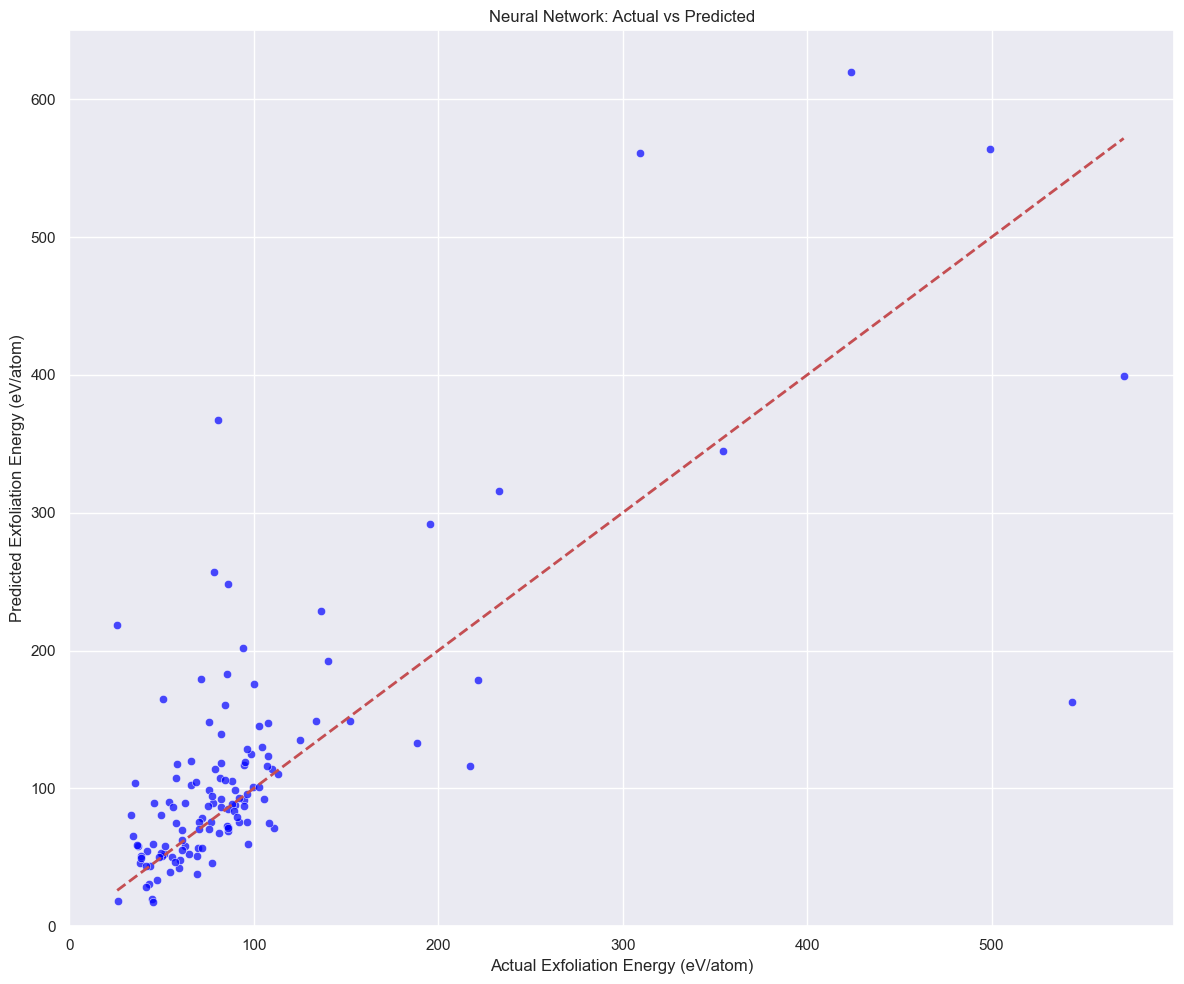

In [8]:
# ===============================================================
# PART F: Neural Network Model
# ===============================================================

print("\n" + "="*70)
print("NEURAL NETWORK (MLP)")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_dist = {
    'nn__hidden_layer_sizes': [
        (128, 64),
        (128, 64, 32),
        (96, 48),
    ],
    'nn__alpha': [0.001, 0.005, 0.01],
    'nn__learning_rate_init': [0.001, 0.002],
    'nn__batch_size': [32, 64],
}

# Base model with better defaults
nn_model = MLPRegressor(
    activation='relu',
    solver='adam',
    max_iter=1500,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=30,
    random_state=42,
)


nn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("nn", nn_model)
])

# Randomized search
print("🔍 Tuning neural network hyperparameters...")
print("   (This will take 2-3 minutes...)")

search = RandomizedSearchCV(
    nn_pipe,
    param_dist,
    n_iter=15,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print(f"\n✅ Best hyperparameters found:")
for param, value in search.best_params_.items():
    print(f"   {param}: {value}")

# Use best model
nn_pipe = search.best_estimator_

# Cross-validation
cv_mae_nn = -cross_val_score(nn_pipe, X, y, scoring="neg_mean_absolute_error", cv=cv)
cv_rmse_nn = np.sqrt(-cross_val_score(nn_pipe, X, y, scoring="neg_mean_squared_error", cv=cv))

print(f"\nCV MAE:  {cv_mae_nn.mean():.3f} ± {cv_mae_nn.std():.3f} eV/atom")
print(f"CV RMSE: {cv_rmse_nn.mean():.3f} ± {cv_rmse_nn.std():.3f} eV/atom")

# Test predictions
y_pred_nn = nn_pipe.predict(X_test)
nn_mae = mean_absolute_error(y_test, y_pred_nn)
nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
nn_test_r2 = r2_score(y_test, y_pred_nn)

# Train predictions
y_train_pred_nn = nn_pipe.predict(X_train)
nn_train_mae = mean_absolute_error(y_train, y_train_pred_nn)
nn_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
nn_train_r2 = r2_score(y_train, y_train_pred_nn)

print(f"\nTest MAE:  {nn_mae:.3f} eV/atom")
print(f"Test RMSE: {nn_rmse:.3f} eV/atom")
print(f"Test R²:   {nn_test_r2:.3f}")
print(f"Improvement vs baseline: {((mae - nn_mae) / mae * 100):.1f}%")

# Overfitting/Underfitting Check
print("\n" + "-"*70)
print("OVERFITTING/UNDERFITTING ANALYSIS:")
print("-"*70)
print(f"Train MAE: {nn_train_mae:.3f} eV/atom")
print(f"Test MAE:  {nn_mae:.3f} eV/atom")
print(f"Train R²:  {nn_train_r2:.3f}")
print(f"Test R²:   {nn_test_r2:.3f}")

nn_gap = nn_mae - nn_train_mae
nn_ratio = nn_mae / nn_train_mae
print(f"\nGap (Test - Train): {nn_gap:.3f} eV/atom")
print(f"Test/Train Ratio:   {nn_ratio:.3f}")

if nn_ratio < 1.05:
    print("⚠️  UNDERFITTING - Model is too simple")
elif 1.05 <= nn_ratio <= 1.20:
    print("✅ GOOD FIT - Healthy generalization")
elif 1.20 < nn_ratio <= 1.40:
    print("⚠️  SLIGHT OVERFITTING - Some memorization")
else:
    print("❌ SEVERE OVERFITTING - Memorizing training data")

# Plot
plt.figure(figsize=(12,10))
sns.scatterplot(x=y_test, y=y_pred_nn, alpha=0.7, color='blue')
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "r--", lw=2)
plt.xlabel("Actual Exfoliation Energy (eV/atom)")
plt.ylabel("Predicted Exfoliation Energy (eV/atom)")
plt.title("Neural Network: Actual vs Predicted")
plt.xlim(0)
plt.ylim(0)
plt.tight_layout()
plt.savefig(FIG_DIR / "nn_predictions.png", dpi=300)
plt.show()


OVERFITTING/UNDERFITTING SUMMARY - ALL MODELS

            Model  Train MAE  Test MAE  Train R²  Test R²  Gap (MAE)  Test/Train Ratio
Linear Regression  59.793136 57.844952  0.514857 0.025659  -1.948184          0.967418
    Random Forest  29.394259 31.843593  0.682963 0.503643   2.449334          1.083327
   Neural Network  38.079531 38.550724  0.530219 0.382419   0.471193          1.012374


/var/folders/yy/g88jcjn92dgfyw5kyn8lg0c80000gn/T/ipykernel_17288/106443751.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(models, rotation=20, ha='right')


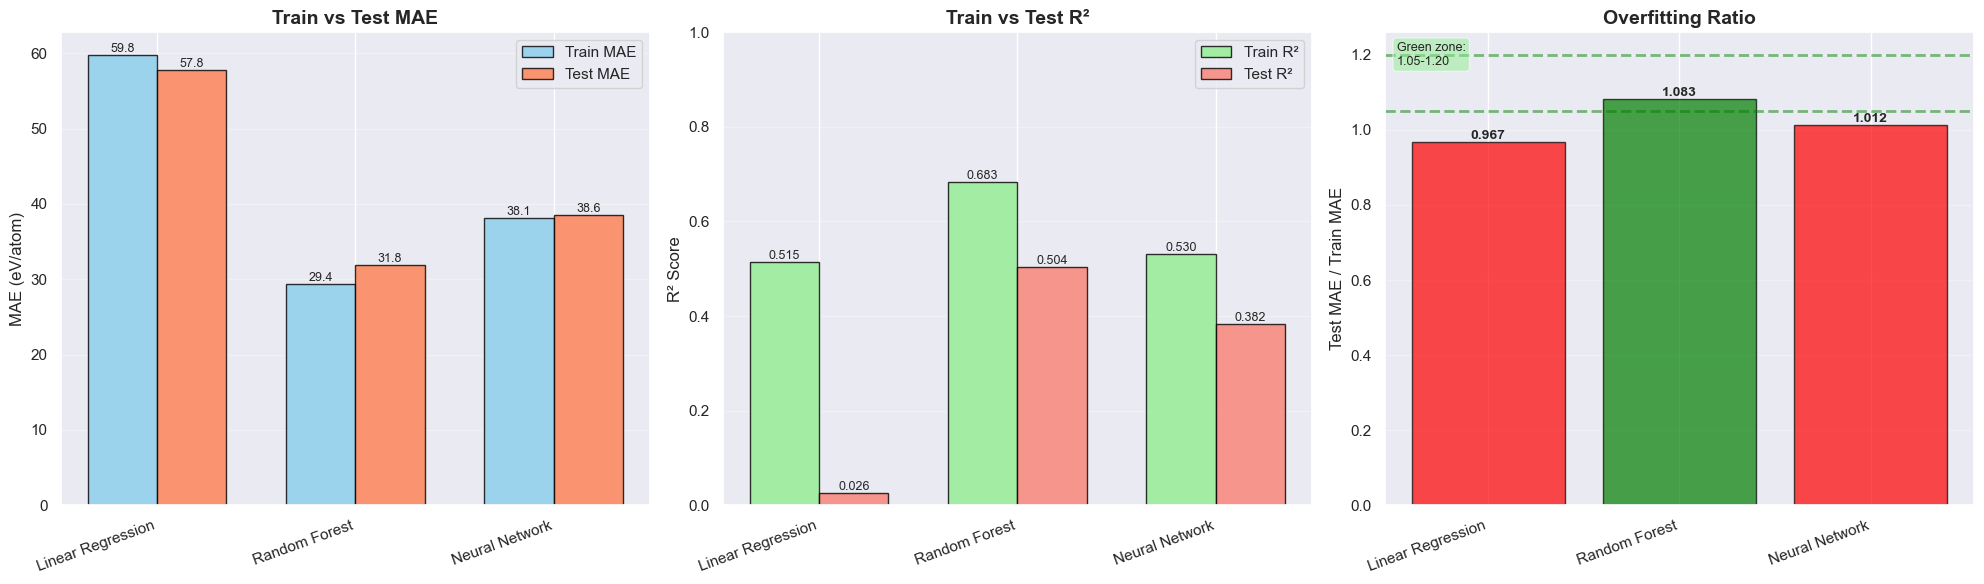


✅ Overfitting analysis saved to ../../data/processed/overfitting_summary.csv


In [9]:
# ===============================================================
# PART G0: Overfitting/Underfitting Summary
# ===============================================================

print("\n" + "="*70)
print("OVERFITTING/UNDERFITTING SUMMARY - ALL MODELS")
print("="*70)

fit_summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Neural Network'],
    'Train MAE': [train_mae, rf_train_mae, nn_train_mae],
    'Test MAE': [mae, rf_mae, nn_mae],
    'Train R²': [train_r2, rf_train_r2, nn_train_r2],
    'Test R²': [test_r2, rf_test_r2, nn_test_r2],
    'Gap (MAE)': [gap, rf_gap, nn_gap],
    'Test/Train Ratio': [ratio, rf_ratio, nn_ratio]
})

print("\n" + fit_summary.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = fit_summary['Model']
x = np.arange(len(models))
width = 0.35

# Plot 1: Train vs Test MAE
axes[0].bar(x - width/2, fit_summary['Train MAE'], width, 
           label='Train MAE', alpha=0.8, color='skyblue', edgecolor='black')
axes[0].bar(x + width/2, fit_summary['Test MAE'], width, 
           label='Test MAE', alpha=0.8, color='coral', edgecolor='black')
axes[0].set_ylabel('MAE (eV/atom)', fontsize=12)
axes[0].set_title('Train vs Test MAE', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=20, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

for i in range(len(models)):
    axes[0].text(i - width/2, fit_summary.iloc[i]['Train MAE'], 
                f'{fit_summary.iloc[i]["Train MAE"]:.1f}', 
                ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, fit_summary.iloc[i]['Test MAE'], 
                f'{fit_summary.iloc[i]["Test MAE"]:.1f}', 
                ha='center', va='bottom', fontsize=9)

# Plot 2: R² Scores
axes[1].bar(x - width/2, fit_summary['Train R²'], width, 
           label='Train R²', alpha=0.8, color='lightgreen', edgecolor='black')
axes[1].bar(x + width/2, fit_summary['Test R²'], width, 
           label='Test R²', alpha=0.8, color='salmon', edgecolor='black')
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Train vs Test R²', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=20, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

for i in range(len(models)):
    axes[1].text(i - width/2, fit_summary.iloc[i]['Train R²'], 
                f'{fit_summary.iloc[i]["Train R²"]:.3f}', 
                ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, fit_summary.iloc[i]['Test R²'], 
                f'{fit_summary.iloc[i]["Test R²"]:.3f}', 
                ha='center', va='bottom', fontsize=9)

# Plot 3: Overfit Ratio
colors_ratio = ['green' if 1.05 <= r <= 1.20 else 'orange' if r > 1.20 else 'red' 
                for r in fit_summary['Test/Train Ratio']]
axes[2].bar(models, fit_summary['Test/Train Ratio'], 
           color=colors_ratio, alpha=0.7, edgecolor='black')
axes[2].axhline(y=1.05, color='green', linestyle='--', linewidth=2, alpha=0.5)
axes[2].axhline(y=1.20, color='green', linestyle='--', linewidth=2, alpha=0.5)
axes[2].set_ylabel('Test MAE / Train MAE', fontsize=12)
axes[2].set_title('Overfitting Ratio', fontsize=14, fontweight='bold')
axes[2].set_xticklabels(models, rotation=20, ha='right')
axes[2].grid(axis='y', alpha=0.3)
axes[2].text(0.02, 0.98, 'Green zone:\n1.05-1.20', transform=axes[2].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

for i, r in enumerate(fit_summary['Test/Train Ratio']):
    axes[2].text(i, r, f'{r:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(FIG_DIR / "overfitting_summary.png", dpi=300, bbox_inches='tight')
plt.show()

fit_summary.to_csv(PROC_DIR / "overfitting_summary.csv", index=False)
print(f"\n✅ Overfitting analysis saved to {PROC_DIR / 'overfitting_summary.csv'}")


MODEL COMPARISON

            Model  Test MAE  Test RMSE
Linear Regression 57.844952  87.674111
    Random Forest 31.843593  62.576723
   Neural Network 38.550724  69.801185

Best model: Random Forest


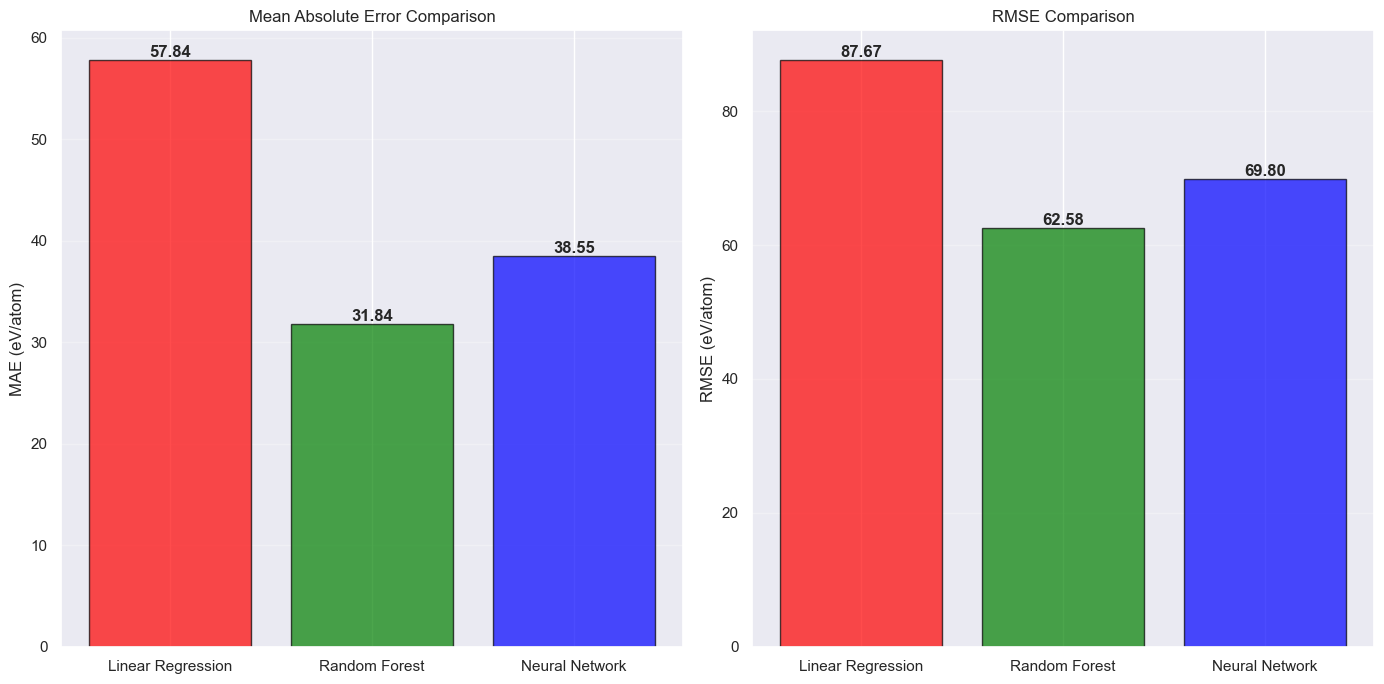

In [10]:
# ===============================================================
# PART G1: Model Comparison
# ===============================================================

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# Summary table
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Neural Network'],
    'Test MAE': [mae, rf_mae, nn_mae],
    'Test RMSE': [rmse, rf_rmse, nn_rmse]
})

print("\n" + results.to_string(index=False))
print(f"\nBest model: {results.loc[results['Test MAE'].idxmin(), 'Model']}")

# Bar plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# MAE comparison
models = results['Model'].tolist()
maes = results['Test MAE'].tolist()
colors = ['red', 'green', 'blue']

axes[0].bar(models, maes, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('MAE (eV/atom)')
axes[0].set_title('Mean Absolute Error Comparison')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(maes):
    axes[0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# RMSE comparison
rmses = results['Test RMSE'].tolist()
axes[1].bar(models, rmses, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('RMSE (eV/atom)')
axes[1].set_title('RMSE Comparison')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmses):
    axes[1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / "model_comparison.png", dpi=300)
plt.show()

# Save results
results.to_csv(PROC_DIR / "model_comparison.csv", index=False)


SHAP ANALYSIS


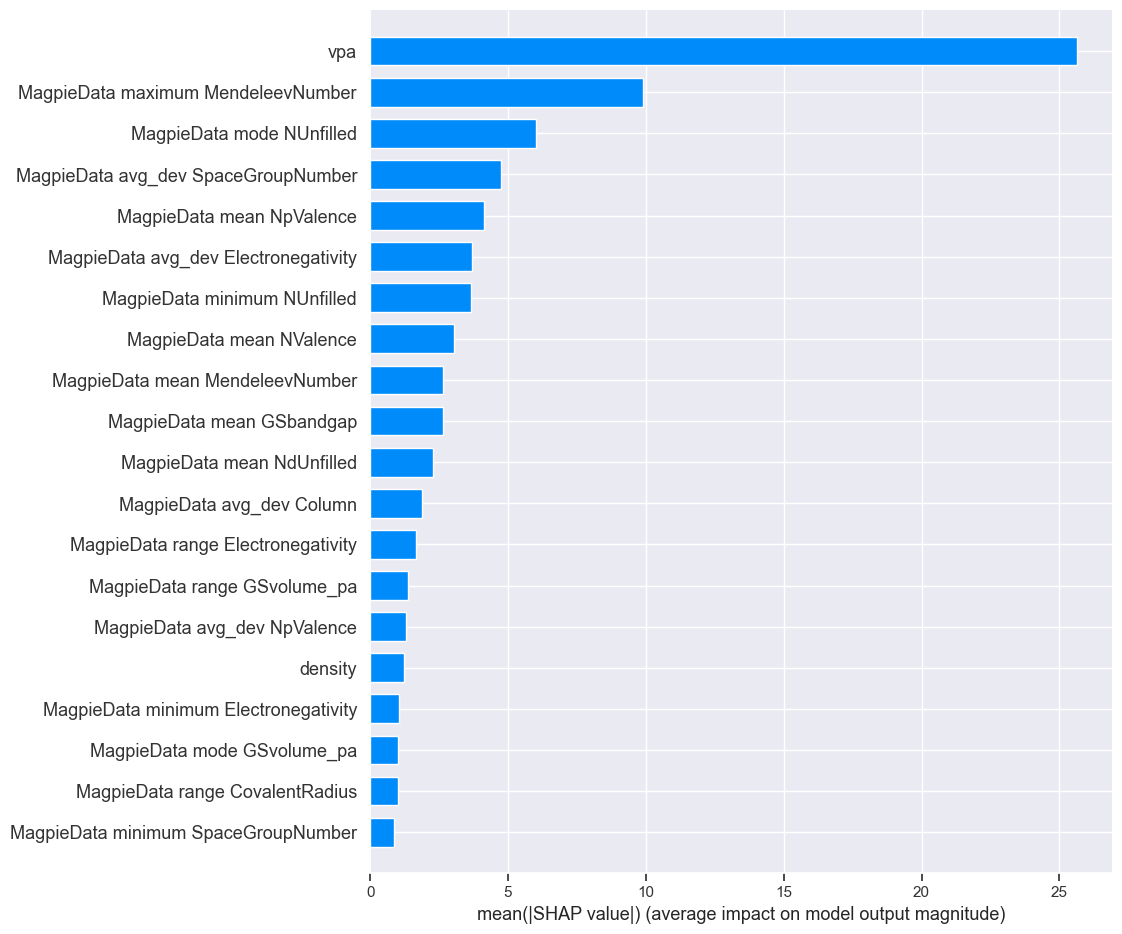

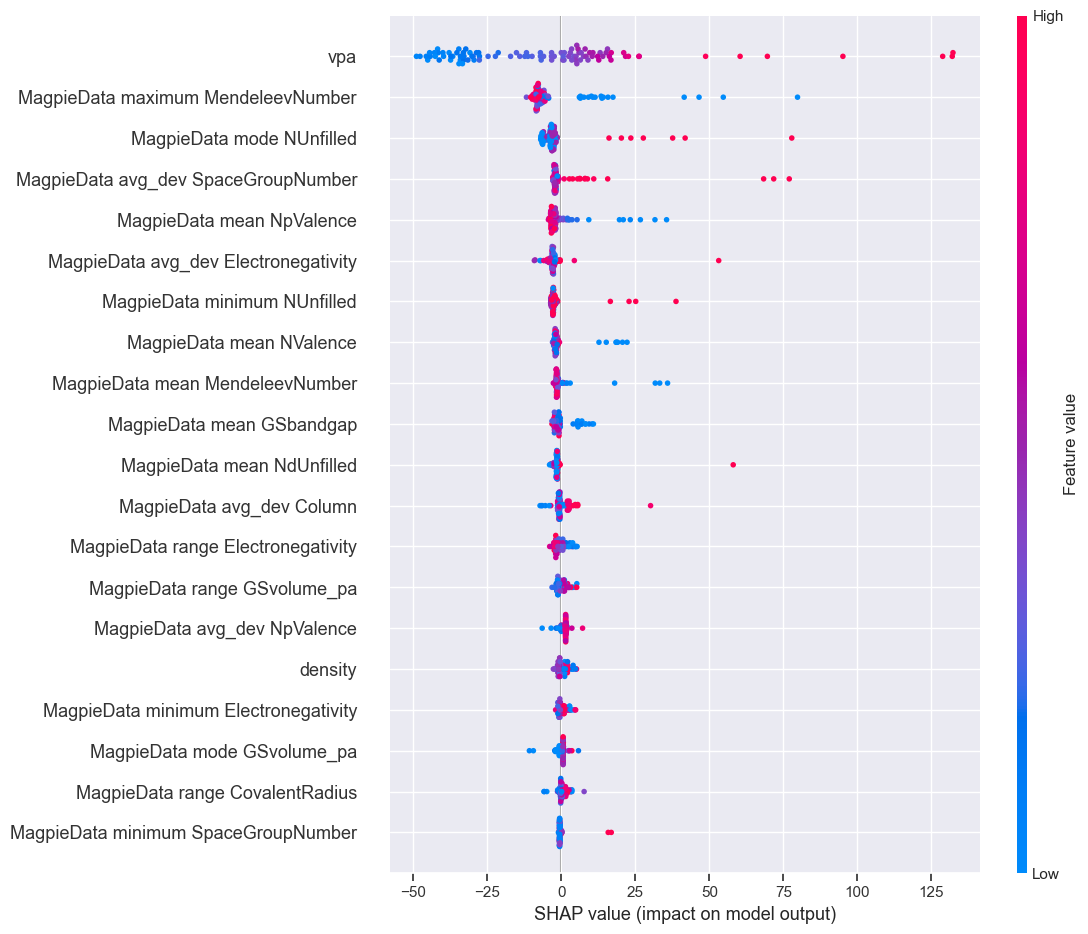

In [11]:
# ===============================================================
# PART G2: SHAP Analysis 
# ===============================================================

print("\n" + "="*70)
print("SHAP ANALYSIS")
print("="*70)

# Use a subset for speed
X_shap = X_test.sample(n=100, random_state=42)

# Create explainer
explainer = shap.TreeExplainer(rf_pipe.named_steps['rf'])
X_shap_scaled = rf_pipe.named_steps['scaler'].transform(X_shap)
shap_values = explainer.shap_values(X_shap_scaled)

# ---------------------------------------------------------------
# SHAP BAR PLOT
# ---------------------------------------------------------------
plt.figure(figsize=(12, 14))
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    max_display=20,
    show=False
)

plt.tight_layout()
plt.subplots_adjust(left=0.05)
plt.savefig(FIG_DIR / "shap_importance.png", dpi=400, bbox_inches="tight")
plt.show()

# ---------------------------------------------------------------
# SHAP BEESWARM
# ---------------------------------------------------------------
plt.figure(figsize=(12, 14))
shap.summary_plot(
    shap_values,
    X_shap,
    max_display=20,
    show=False
)

plt.tight_layout()
plt.subplots_adjust(left=0.05)
plt.savefig(FIG_DIR / "shap_summary.png", dpi=400, bbox_inches="tight")
plt.show()

In [13]:
# ===============================================================
# PART G3: Final Summary
# ===============================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\nDataset: MatBench JDFT-2D ({len(df_feat)} samples)")
print(f"Features: {len(X.columns)} compositional + structural descriptors (reduced from 137 via feature selection)")
print(f"\nResults:")
print(f"  Baseline (Linear):  MAE = {mae:.3f} eV/atom")
print(f"  Random Forest:      MAE = {rf_mae:.3f} eV/atom ({((mae-rf_mae)/mae*100):.1f}% better)")
print(f"  Neural Network:     MAE = {nn_mae:.3f} eV/atom ({((mae-nn_mae)/mae*100):.1f}% better)")
print(f"\n✅ Project complete! All figures saved to {FIG_DIR}")
print("="*70)


FINAL SUMMARY

Dataset: MatBench JDFT-2D (635 samples)
Features: 94 compositional + structural descriptors (reduced from 137 via feature selection)

Results:
  Baseline (Linear):  MAE = 57.845 eV/atom
  Random Forest:      MAE = 31.844 eV/atom (45.0% better)
  Neural Network:     MAE = 38.551 eV/atom (33.4% better)

✅ Project complete! All figures saved to ../../figures



HIGH EXFOLIATION ENERGY FAILURE ANALYSIS

MAE BY EXFOLIATION ENERGY RANGE:

Energy Range (meV)  N Samples  Mean Actual (meV)  Linear Regression MAE  Random Forest MAE  Neural Network MAE
             0-100         99          68.064054              48.203535          25.141292           29.951884
           100-200         19         123.730329              60.695609          30.680611           33.116221
           200-300          3         223.939506              53.235553          14.352976           75.646146
           300-400          2         331.889733             191.236450          32.536192          130.327602
           400-500          2         461.450042             131.074281         102.398334          130.371073
              500+          2         557.564000             308.307146         329.644446          276.580731

LOW VS HIGH ENERGY COMPARISON:

Samples with E ≤ 300 meV: 121
Samples with E > 300 meV: 6
Imbalance ratio: 20.17:1

Linear Regression:
  MAE (E ≤

/var/folders/yy/g88jcjn92dgfyw5kyn8lg0c80000gn/T/ipykernel_17288/262269019.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(df_bins['Energy Range (meV)'], rotation=45, ha='right', fontsize=9)


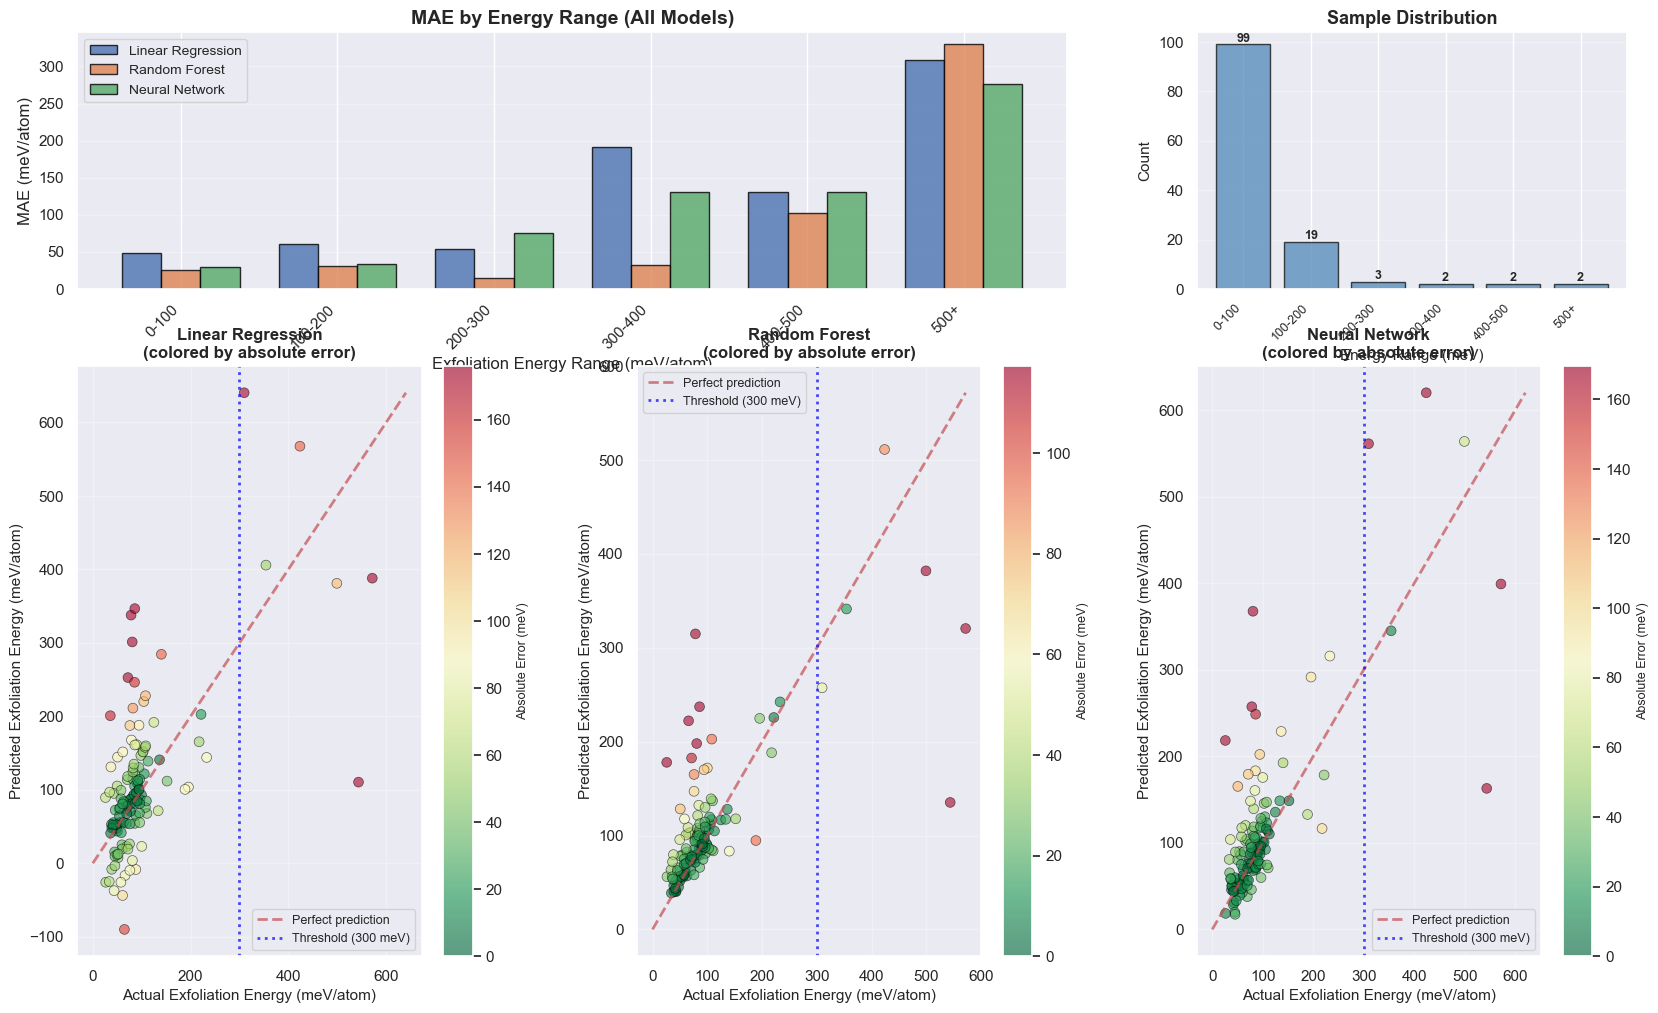


FEATURE CHARACTERISTICS: LOW VS HIGH ENERGY

Top 5 most correlated features:

MagpieData maximum MendeleevNumber:
  Low energy:  91.438 ± 3.575
  High energy: 81.667 ± 8.116
  Difference:  9.771 (10.7%)

MagpieData maximum Column:
  Low energy:  16.405 ± 0.600
  High energy: 14.500 ± 1.871
  Difference:  1.905 (11.6%)

vpa:
  Low energy:  95.330 ± 35.408
  High energy: 144.873 ± 56.975
  Difference:  49.543 (52.0%)

MagpieData mode NUnfilled:
  Low energy:  1.587 ± 0.910
  High energy: 3.000 ± 3.162
  Difference:  1.413 (89.1%)

MagpieData mean NpValence:
  Low energy:  3.015 ± 0.711
  High energy: 1.667 ± 1.229
  Difference:  1.348 (44.7%)

✅ High energy analysis saved to ../../data/processed/high_energy_analysis.csv

CONCLUSIONS:
1. DATA IMBALANCE: Check if high-energy samples are underrepresented
2. FEATURE LIMITS: Features may saturate or behave differently at extremes
3. MODEL BIAS: All models optimize for the dense low-energy region
4. PHYSICS: High exfoliation energies may invo

In [16]:
# ===============================================================
# PART H: High Exfoliation Energy Failure Analysis
# ===============================================================

print("\n" + "="*70)
print("HIGH EXFOLIATION ENERGY FAILURE ANALYSIS")
print("="*70)

# Convert to meV for easier interpretation (values are already in meV based on your summary)
y_test_reset = y_test.reset_index(drop=True)

# Get predictions for all models
predictions = {
    'Linear Regression': pipe.predict(X_test),
    'Random Forest': rf_pipe.predict(X_test),
    'Neural Network': nn_pipe.predict(X_test)
}

# Create energy bins
bins = [0, 100, 200, 300, 400, 500, y_test_reset.max() + 1]
bin_labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500+']
binned = pd.cut(y_test_reset, bins=bins, labels=bin_labels)

# Calculate MAE and sample count for each bin
print("\n" + "="*70)
print("MAE BY EXFOLIATION ENERGY RANGE:")
print("="*70)

bin_results = []
for bin_label in bin_labels:
    mask = binned == bin_label
    n_samples = mask.sum()
    
    if n_samples > 0:
        actual = y_test_reset[mask]
        
        row = {
            'Energy Range (meV)': bin_label,
            'N Samples': n_samples,
            'Mean Actual (meV)': actual.mean(),
            'Std Actual (meV)': actual.std()
        }
        
        for model_name, preds in predictions.items():
            mae_bin = mean_absolute_error(actual, preds[mask])
            rel_error = (mae_bin / actual.mean() * 100) if actual.mean() > 0 else 0
            row[f'{model_name} MAE'] = mae_bin
            row[f'{model_name} Rel%'] = rel_error
        
        bin_results.append(row)

df_bins = pd.DataFrame(bin_results)
print("\n" + df_bins[['Energy Range (meV)', 'N Samples', 'Mean Actual (meV)', 
                       'Linear Regression MAE', 'Random Forest MAE', 'Neural Network MAE']].to_string(index=False))

# Key insight: Compare low vs high energy
print("\n" + "="*70)
print("LOW VS HIGH ENERGY COMPARISON:")
print("="*70)

threshold = 300  # meV
low_mask = y_test_reset <= threshold
high_mask = y_test_reset > threshold

print(f"\nSamples with E ≤ {threshold} meV: {low_mask.sum()}")
print(f"Samples with E > {threshold} meV: {high_mask.sum()}")
print(f"Imbalance ratio: {low_mask.sum() / high_mask.sum():.2f}:1")

for model_name, preds in predictions.items():
    low_mae = mean_absolute_error(y_test_reset[low_mask], preds[low_mask])
    high_mae = mean_absolute_error(y_test_reset[high_mask], preds[high_mask])
    
    print(f"\n{model_name}:")
    print(f"  MAE (E ≤ {threshold} meV): {low_mae:.2f} meV")
    print(f"  MAE (E > {threshold} meV): {high_mae:.2f} meV")
    print(f"  → High energy is {high_mae/low_mae:.2f}x worse")

# Visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: MAE by energy range (all models)
ax1 = fig.add_subplot(gs[0, :2])
x_pos = np.arange(len(df_bins))
width = 0.25

for i, model in enumerate(['Linear Regression', 'Random Forest', 'Neural Network']):
    offset = (i - 1) * width
    maes = df_bins[f'{model} MAE'].values
    ax1.bar(x_pos + offset, maes, width, label=model, alpha=0.8, edgecolor='black')

ax1.set_xlabel('Exfoliation Energy Range (meV/atom)', fontsize=12)
ax1.set_ylabel('MAE (meV/atom)', fontsize=12)
ax1.set_title('MAE by Energy Range (All Models)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_bins['Energy Range (meV)'], rotation=45, ha='right')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Sample distribution
ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(df_bins['Energy Range (meV)'], df_bins['N Samples'], 
       alpha=0.7, color='steelblue', edgecolor='black')
ax2.set_xlabel('Energy Range (meV)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Sample Distribution', fontsize=13, fontweight='bold')
ax2.set_xticklabels(df_bins['Energy Range (meV)'], rotation=45, ha='right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(df_bins['N Samples']):
    ax2.text(i, v, str(v), ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3-5: Actual vs Predicted for each model (colored by error)
for idx, (model_name, preds) in enumerate(predictions.items()):
    ax = fig.add_subplot(gs[1:, idx])
    
    errors = np.abs(y_test_reset - preds)
    scatter = ax.scatter(y_test_reset, preds, c=errors, cmap='RdYlGn_r', 
                        alpha=0.6, s=50, edgecolors='black', linewidth=0.5,
                        vmin=0, vmax=np.percentile(errors, 95))
    
    # Perfect prediction line
    lims = [0, max(y_test_reset.max(), preds.max())]
    ax.plot(lims, lims, 'r--', lw=2, label='Perfect prediction', alpha=0.7)
    
    # Add threshold line
    ax.axvline(threshold, color='blue', linestyle=':', lw=2, alpha=0.7, 
              label=f'Threshold ({threshold} meV)')
    
    ax.set_xlabel('Actual Exfoliation Energy (meV/atom)', fontsize=11)
    ax.set_ylabel('Predicted Exfoliation Energy (meV/atom)', fontsize=11)
    ax.set_title(f'{model_name}\n(colored by absolute error)', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Absolute Error (meV)', fontsize=9)

plt.savefig(FIG_DIR / "high_energy_failure_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis: Feature statistics for high vs low energy
print("\n" + "="*70)
print("FEATURE CHARACTERISTICS: LOW VS HIGH ENERGY")
print("="*70)

X_test_reset = X_test.reset_index(drop=True)

top_5_features = [feat for feat in target_corr.head(20).index if feat in X_test.columns][:5]

print(f"\nTop 5 most correlated features:")
for feat in top_5_features:
    low_mean = X_test_reset.loc[low_mask, feat].mean()
    high_mean = X_test_reset.loc[high_mask, feat].mean()
    low_std = X_test_reset.loc[low_mask, feat].std()
    high_std = X_test_reset.loc[high_mask, feat].std()
    
    print(f"\n{feat}:")
    print(f"  Low energy:  {low_mean:.3f} ± {low_std:.3f}")
    print(f"  High energy: {high_mean:.3f} ± {high_std:.3f}")
    print(f"  Difference:  {abs(high_mean - low_mean):.3f} ({abs(high_mean - low_mean)/low_mean*100:.1f}%)")

# Save results
df_bins.to_csv(PROC_DIR / "high_energy_analysis.csv", index=False)
print(f"\n✅ High energy analysis saved to {PROC_DIR / 'high_energy_analysis.csv'}")

print("\n" + "="*70)
print("CONCLUSIONS:")
print("="*70)
print("1. DATA IMBALANCE: Check if high-energy samples are underrepresented")
print("2. FEATURE LIMITS: Features may saturate or behave differently at extremes")
print("3. MODEL BIAS: All models optimize for the dense low-energy region")
print("4. PHYSICS: High exfoliation energies may involve different bonding mechanisms")
print("="*70)

In [15]:
print("\n================ PROJECT SUMMARY SNAPSHOT ================\n")

# 1. Linear Regression
print("LINEAR REGRESSION:")
print(f"  Test MAE:  {mae:.4f}")
print(f"  Test RMSE: {rmse:.4f}\n")

# 2. Random Forest
print("RANDOM FOREST:")
print(f"  Test MAE:  {rf_mae:.4f}")
print(f"  Test RMSE: {rf_rmse:.4f}")
print(f"  Improvement vs baseline: {(mae - rf_mae) / mae * 100:.2f}%\n")

# 3. Neural Network
print("NEURAL NETWORK:")
print(f"  Test MAE:  {nn_mae:.4f}")
print(f"  Test RMSE: {nn_rmse:.4f}")
print(f"  Improvement vs baseline: {(mae - nn_mae) / mae * 100:.2f}%")

# Optional: best params if available
try:
    print("\nBest NN Params:")
    print(search.best_params_)
except:
    print("\nBest NN Params: (no hyperparameter search info available)")

# 4. Dataset Size After Featurization
print("\nDATASET SIZE (after featurization & cleaning):")
print(f"  df_feat shape: {df_feat.shape}\n")

# 5. Top Correlated Features
print("TOP 10 FEATURES CORRELATED WITH TARGET:")
for i, (feat, corr_val) in enumerate(target_corr.head(10).items(), 1):
    print(f"  {i:2d}. {feat:40s} |r| = {corr_val:.4f}")

print("\n================ END OF SUMMARY ================\n")


================ PROJECT SUMMARY SNAPSHOT ================

LINEAR REGRESSION:
  Test MAE:  57.8450
  Test RMSE: 87.6741

RANDOM FOREST:
  Test MAE:  31.8436
  Test RMSE: 62.5767
  Improvement vs baseline: 44.95%

NEURAL NETWORK:
  Test MAE:  38.5507
  Test RMSE: 69.8012
  Improvement vs baseline: 33.36%

Best NN Params:
{'nn__learning_rate_init': 0.002, 'nn__hidden_layer_sizes': (128, 64), 'nn__batch_size': 32, 'nn__alpha': 0.005}

DATASET SIZE (after featurization & cleaning):
  df_feat shape: (635, 136)

TOP 10 FEATURES CORRELATED WITH TARGET:
   1. MagpieData maximum MendeleevNumber       |r| = 0.3367
   2. MagpieData maximum NpValence             |r| = 0.3161
   3. MagpieData maximum Column                |r| = 0.3147
   4. vpa                                      |r| = 0.3124
   5. MagpieData mode GSmagmom                 |r| = 0.2626
   6. MagpieData mode NUnfilled                |r| = 0.2613
   7. MagpieData mean NpValence                |r| = 0.2519
   8. MagpieData mode NdUn